# Initial settings

In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

#Libraries
import yaml
import math
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import datasets as datasets_torch
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    RandomHorizontalFlip,
    ToTensor,
    Normalize,
    InterpolationMode,
)
import wandb
import datasets, diffusers
from datasets import load_dataset
from diffusers import UNet2DModel, DDPMScheduler, AutoencoderKL
from diffusers import DDPMPipeline
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
import logging
from accelerate.logging import get_logger
from accelerate import Accelerator

import torchvision
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from PIL import Image
import csv
import cv2 as cv

selected_gpu = 0 #select the GPU to use
device = torch.device("cuda:" + str(selected_gpu) if torch.cuda.is_available() else "cpu")
print(f'The device is: {device}\n')

# load the config file
with open('config_playground.yaml') as file: # expects the config file to be in the same directory
    config = yaml.load(file, Loader=yaml.FullLoader)
    
# define logging directory
pipeline_dir = repo_path / config['saving']['local']['outputs_dir'] / config['saving']['local']['pipeline_name']
logging_dir = pipeline_dir / config['logging']['dir_name']

# start the accelerator
accelerator = Accelerator(
    gradient_accumulation_steps=config['training']['gradient_accumulation']['steps'],
    mixed_precision=config['training']['mixed_precision']['type'],
    log_with= config['logging']['logger_name'],
    logging_dir= logging_dir,
)

# show the accelerator state as first log message
print(accelerator.state)

# define data directory
data_dir = repo_path / config['processing']['dataset']

The device is: cuda:0

Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda
Mixed precision type: no



# Loading and more

## Get maximum values among all images

## Load data with custom dataset

In [113]:
# create a dataset class for our breast images
class breast_dataset(torch.utils.data.Dataset):
    def __init__(self, csv_path: Path, images_dir: Path, transform=None):
        """_summary_

        Args:
            csv_path (Path): path to the csv file with the filenames
            images_dir (Path): path to the folder with the images
            transform (function, optional): transformation function. Usually pytorch.Transform. Defaults to None.
        """
        self.names = pd.read_csv(csv_path, header=None) # read csv file
        self.images_dir = images_dir # path to image folder
        self.transform = transform # transform to apply to images
    
    def __len__(self):
        """returns the length of the dataset

        Returns:
            int: length of the dataset
        """
        return len(self.names)
    
    def __getitem__(self, idx: int):
        """returns the image at index idx

        Args:
            idx (int): index in the csv file

        Returns:
            PIL.Image: PIL image
        """
        img_path = self.images_dir / self.names.iloc[idx, 0] # get image path
        image = Image.open(img_path) # open image
        # image = np.array(image, dtype=np.float32) # convert to numpy array
        if self.transform: # apply transform if it exists
            image = self.transform(image)
            
        return image
    
    def set_transform(self, transform):
        """set the transform to apply to the images

        Args:
            transform (function): transform to apply to the images
        """
        self.transform = transform

    def __repr__(self) -> str:
        return f"({len(self)} images)"

def load_breast_dataset(folder_dir:Path):
    # get directory name
    folder_name = folder_dir.name
    # check if the csv file with the filenames already exists
    csv_path = folder_dir.parent.parent / 'filenames' / f'{folder_name}.csv'
    if not csv_path.exists(): # if not, create it
        with open(csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            for filename in os.listdir(folder_dir):
                if filename.endswith(".png"):
                    writer.writerow([filename])
    # now we can create the dataset
    dataset = breast_dataset(csv_path, images_dir= folder_dir)
    
    return dataset    

class ToFloat32Tensor(object):
    """
    Converts a PIL Image to a PyTorch tensor with dtype float32, and normalises it.
    """
    def __call__(self, image):
        # Convert PIL Image to PyTorch tensor with dtype float32
        tensor = ToTensor()(image).float()/config['processing']['normalisation_value']
        return tensor

In [139]:
dataset_mine = load_breast_dataset(data_dir)

preprocess = Compose(
    [
        Resize(config['processing']['resolution'], interpolation= InterpolationMode.BILINEAR), #resize image to square keeping aspect ratio
        CenterCrop(config['processing']['resolution']), # crop image to the center
        ToFloat32Tensor(), # convert to tensor with float16 dtype
        Normalize(mean=[0.5], std=[0.5]), # normalise to [-1,1] (mean and std of the dataset
    ]
)
# set transform
dataset_mine.set_transform(preprocess)

# Create the dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset_mine, batch_size=config['processing']['batch_size'], num_workers= 0, shuffle=True
)

# get an example batch
xb = next(iter(train_dataloader))

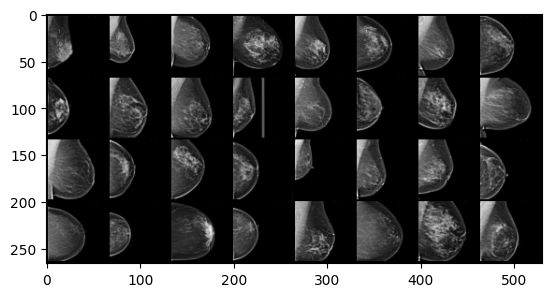

In [140]:
x = xb
grid = torchvision.utils.make_grid(x,normalize=True)
grid_im = grid.detach().cpu().permute(1,2,0).numpy()
plt.imshow(grid_im, cmap='gray')

In [10]:
gray_example = xb[0,0]
# max value
print(f'Max value: {gray_example.max()}')

Max value: 6813.83154296875


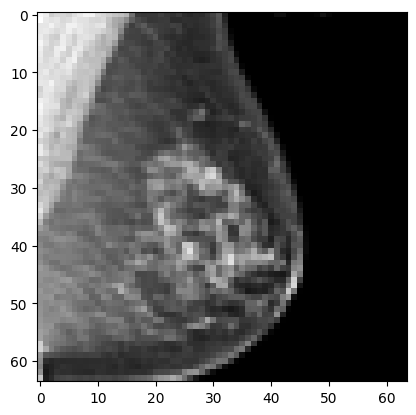

In [34]:
example = xb[0,0].cpu().numpy()
# plot the example
import matplotlib.pyplot as plt
plt.imshow(example, cmap='gray')

## Load model

In [4]:
from huggingface_hub import get_full_repo_name
from diffusers import DDPMPipeline

# Let's give our new model a name for the Hub
model_name = "Latent_Breast_unconditional_noboost"
hub_model_id = get_full_repo_name(model_name)

# load pipeline
pipeline = DDPMPipeline.from_pretrained(hub_model_id)
# load vae model
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Set the noise scheduler
scheduler = pipeline.scheduler
# model
model = pipeline.unet

# send them to device
model.to(device)
vae.to(device);

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
scheduler.init_noise_sigma

1.0

In [14]:
# HP
image_size = 64
batch_size = 8

latents = torch.randn((batch_size, model.in_channels, image_size, image_size))
# Random starting point (8 random images):
latents = latents.to(device)
latents = latents * scheduler.init_noise_sigma

for i, t in enumerate(tqdm(scheduler.timesteps)):
    latent_model_input = scheduler.scale_model_input(latents, t)
    with torch.no_grad(): # Get model prediction
        noise_pred = model(latent_model_input, t).sample

    # Update sample with step
    latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample
image = image.cpu().numpy()

100%|██████████| 1000/1000 [00:38<00:00, 25.75it/s]


In [15]:
image.shape

(8, 3, 512, 512)

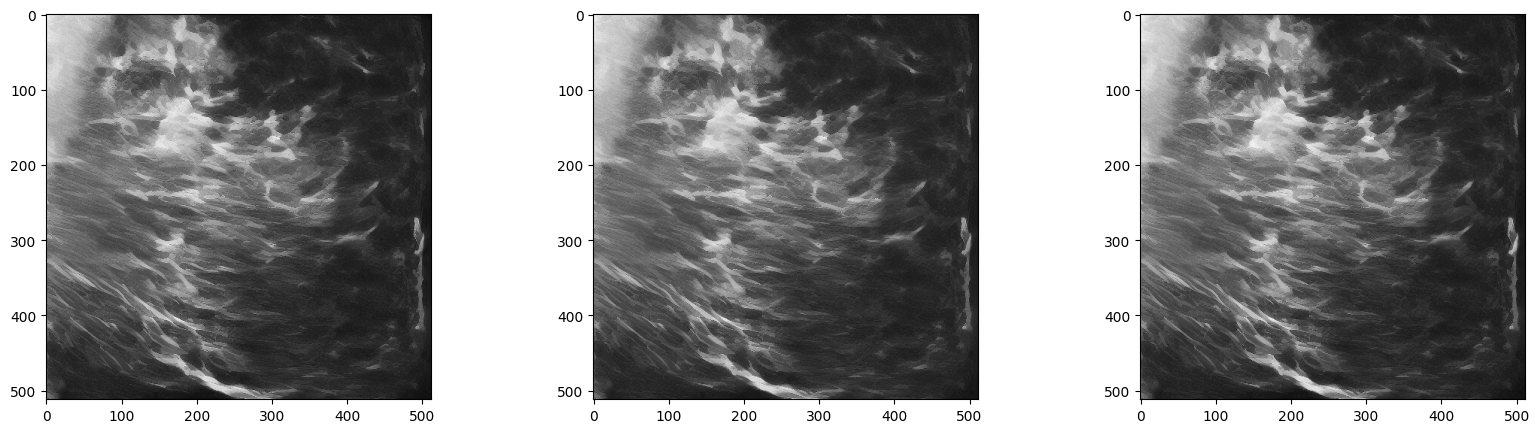

In [27]:
im = image[7]
# plot decoded
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(im[0], cmap='gray')
ax[1].imshow(im[1], cmap='gray')
ax[2].imshow(im[2], cmap='gray')

## For latent space

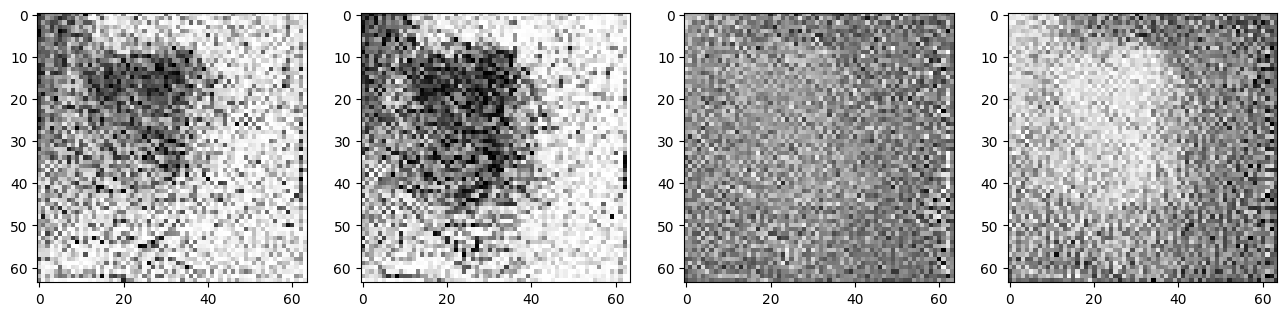

In [8]:
encoded = sample*0.18215 # rescale using vae scaling factor
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

In [10]:
def pil_to_latent(im_resized):
    
    # turn to tensor and normalize
    im_tensor = torch.tensor(im_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    im_tensor = im_tensor.expand(-1, 3, -1, -1) # the same image is repeated three times
    # normalize to 0-1
    im_tensor = im_tensor/im_tensor.max()
    # normalize to -1 to 1
    im_tensor = im_tensor*2 - 1
    with torch.no_grad():
        latent = vae.encode(im_tensor).latent_dist.sample()
    return 0.18215*latent

def latent_to_pil(latents):
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        im_recon = vae.decode(latents).sample
    im_recon = (im_recon.cpu().detach() + 1)/2
    im_recon = im_recon*4095
    return im_recon # zero to one
    

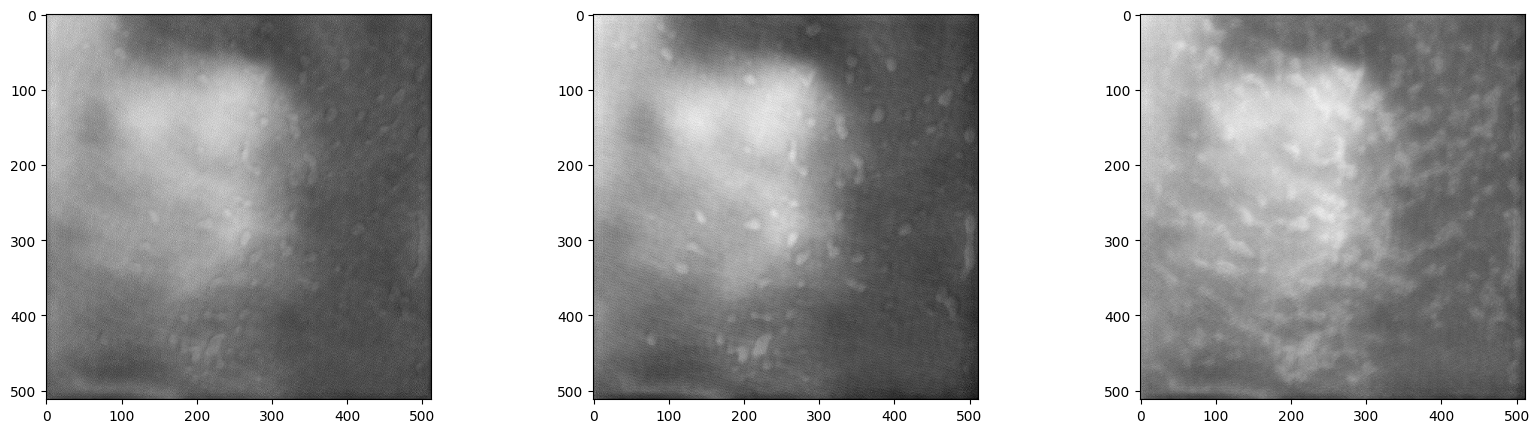

In [11]:
decoded = latent_to_pil(encoded)

# plot decoded
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(decoded[0][0], cmap='gray')
ax[1].imshow(decoded[0][1], cmap='gray')
ax[2].imshow(decoded[0][2], cmap='gray')

# Variational Autoencoder

We use VAE to 'compress' the images. The latent space is 2D, so we can plot it.

## Changing the input and output channels

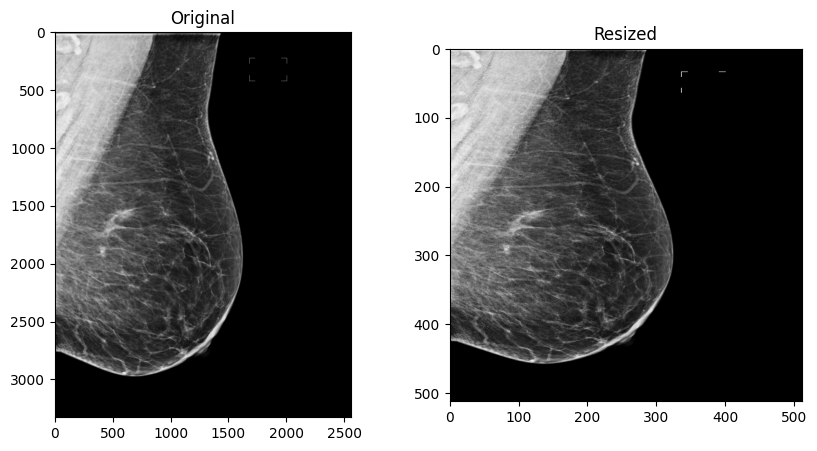

In [4]:
# get an example image
im_path = repo_path / 'data/images/breast10p/1.2.826.0.1.3680043.9.3218.1.1.133376.8684.1511961897765.10235.0.png'
# read image
im = Image.open(im_path)
im = np.array(im, dtype=np.float32)
# resize to 512x512
im_resized = cv.resize(src=im, dsize=(512, 512))

# show original image

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(im_resized, cmap='gray')
ax[1].set_title('Resized')

# turn to tensor and normalize
im_tensor = torch.tensor(im_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
# normalize to 0-1
im_tensor = im_tensor/im_tensor.max()
# normalize to -1 to 1
im_tensor = im_tensor*2 - 1

In [5]:
# load vae model
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.requires_grad_(False)
# change input to one channel
vae.encoder.conv_in = torch.nn.Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# change output to one channel
vae.decoder.conv_out = torch.nn.Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# move to device
vae.to(device)
# clear cache
torch.cuda.empty_cache()

In [6]:
# encode image
with torch.no_grad():
    z = vae.encode(im_tensor).latent_dist.sample()
z.shape

torch.Size([1, 4, 64, 64])

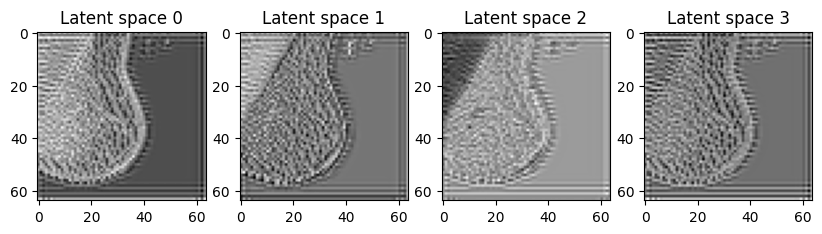

In [8]:
# show images in latent space
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    ax[i].imshow(z[0][i].cpu().detach().numpy(), cmap='gray')
    ax[i].set_title(f'Latent space {i}')
# clear cache
torch.cuda.empty_cache()

In [9]:
# take the image back to the image space
with torch.no_grad():
    im_recon = vae.decode(z).sample

Text(0.5, 1.0, 'Reconstructed')

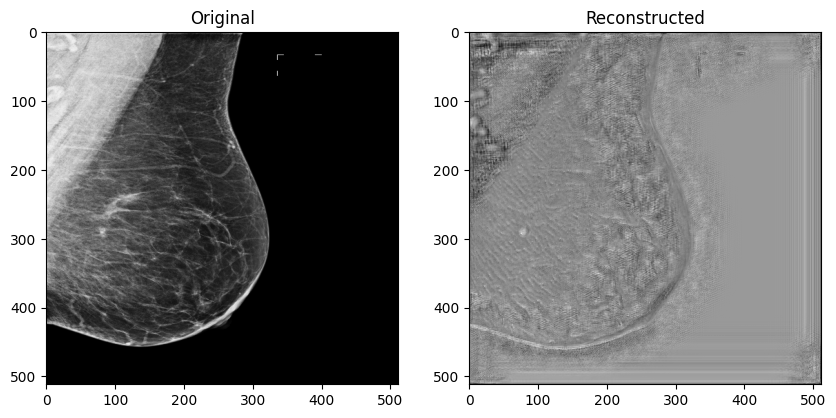

In [19]:
# send to cpu
im_again = (im_recon.cpu().detach() + 1)/2

im_again * torch.tensor(im_resized, dtype=torch.float32)

# show image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im_resized, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(im_again[0][0].numpy(), cmap='gray')
ax[1].set_title('Reconstructed')

In [16]:
torch.tensor(im_resized, dtype=torch.float32).max()

tensor(4095.)

## Giving the same images as three channels

Text(0.5, 1.0, 'Resized')

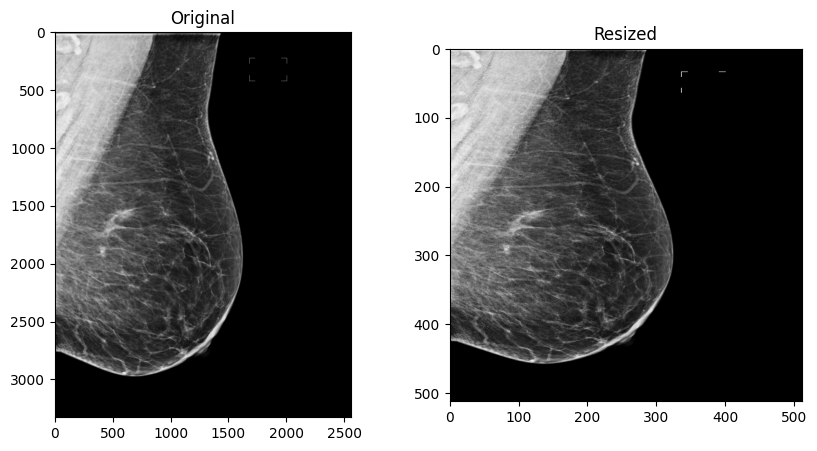

In [2]:
# get an example image
im_path = repo_path / 'data/images/breast10p/1.2.826.0.1.3680043.9.3218.1.1.133376.8684.1511961897765.10235.0.png'
# read image
im = Image.open(im_path)
im = np.array(im, dtype=np.float32)
# resize to 512x512
im_resized = cv.resize(src=im, dsize=(512, 512))

# show original image

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(im_resized, cmap='gray')
ax[1].set_title('Resized')

In [3]:
def pil_to_latent(im_resized):
    
    # turn to tensor and normalize
    im_tensor = torch.tensor(im_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    im_tensor = im_tensor.expand(-1, 3, -1, -1) # the same image is repeated three times
    # normalize to 0-1
    im_tensor = im_tensor/im_tensor.max()
    # normalize to -1 to 1
    im_tensor = im_tensor*2 - 1
    with torch.no_grad():
        latent = vae.encode(im_tensor).latent_dist.sample()
    return 0.18215*latent

def latent_to_pil(latents):
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        im_recon = vae.decode(latents).sample
    im_recon = (im_recon.cpu().detach() + 1)/2
    im_recon = im_recon*4095
    return im_recon # zero to one
    

In [5]:
# load vae model
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.to(device);

In [18]:
# encode image
encoded = pil_to_latent(im_resized)

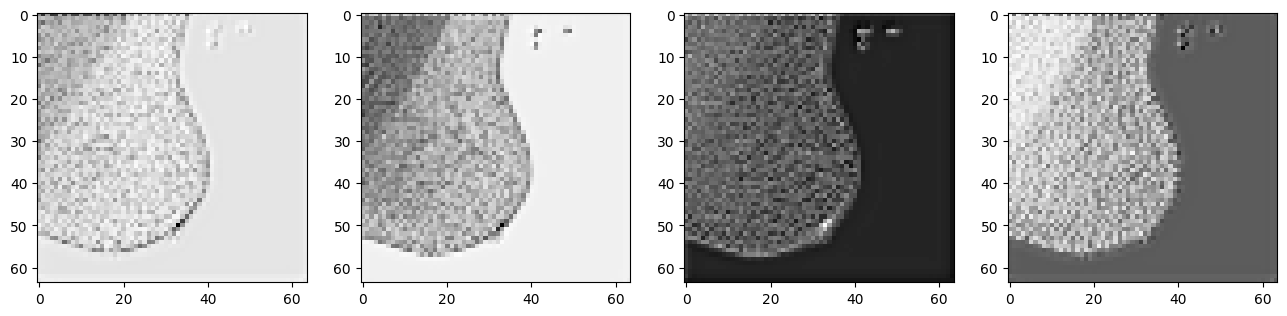

In [19]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

In [48]:
# now decoding
decoded = latent_to_pil(encoded)

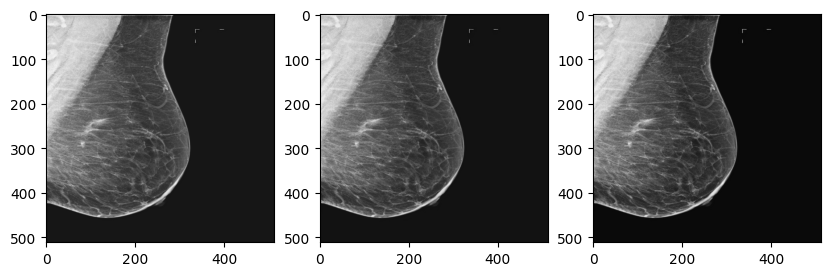

In [50]:
# plot decoded
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(decoded[0][0], cmap='gray')
ax[1].imshow(decoded[0][1], cmap='gray')
ax[2].imshow(decoded[0][2], cmap='gray')

Text(0.5, 1.0, 'Channel 2')

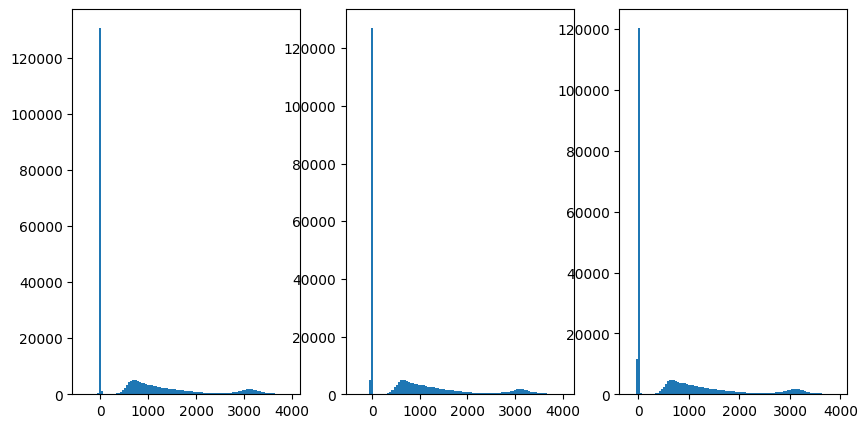

In [52]:
# get histogram of the three channels
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].hist(decoded[0][0].flatten(), bins=100)
ax[1].hist(decoded[0][1].flatten(), bins=100)
ax[2].hist(decoded[0][2].flatten(), bins=100)
axs[0].set_title('Channel 0')
axs[1].set_title('Channel 1')
axs[2].set_title('Channel 2')

Text(0.5, 1.0, 'Reconstructed')

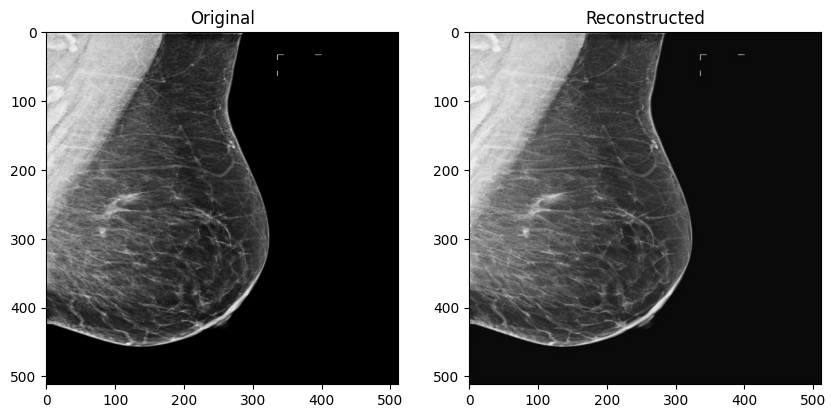

In [54]:
# compare original image with one channel
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im_resized, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(decoded[0][2], cmap='gray')
ax[1].set_title('Reconstructed')